In [1]:
# Import Statements
import sys
import copy
import time
import eeg_utils
import numpy as np
from eeg_utils import *
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2, L1L2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Bidirectional, Flatten
from tensorflow.keras.layers import Reshape, ConvLSTM2D, Attention
from tensorflow.keras.layers import Dense, Dropout, ELU, ReLU, MaxPooling2D 
from tensorflow.keras.layers import LSTM, Maximum, BatchNormalization, Conv2D

In [2]:
# Detect GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [3]:
# Load EEG Data
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [4]:
# Visualize EEG Data Shapes
print("Training/Valid data shape: {}".format(X_train_valid.shape))
print("Test data shape: {}".format(X_test.shape))
print("Training/Valid target shape: {}".format(y_train_valid.shape))
print("Test target shape: {}".format(y_test.shape))
print("Person train/valid shape: {}".format(person_train_valid.shape))
print("Person test shape: {}".format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [5]:
# [RUN IFF] Train on Subject One ONLY
patient_data = []
patient_truths = []

test_data = []
test_truths = []

'''
for patient in np.unique(person_train_valid):
    idx = np.where(person_train_valid == patient)[0]
    patient_data.append(X_train_valid[idx, :, :])
    patient_truths.append(y_train_valid[idx])
    pass'''

# ALso split the testing set, as we want to optimize on subject one
for patient in np.unique(person_test):
    idx = np.where(person_test == patient)[0]
    test_data.append(X_test[idx, :, :])
    test_truths.append(y_test[idx])
    pass

# X_train_valid = patient_data[0]
# y_train_valid = patient_truths[0]
X_test = test_data[0]
y_test = test_truths[0]

In [6]:
# Preprocess and Split Training Data
data_config = {"Duplicate": 2, "Mu": 0.0, "Sigma": 0.5, "Attention": False, "Swap": True}
X_train_valid, y_train_valid, X_test, y_test = preprocess_data(X_train_valid,
                                                               y_train_valid,
                                                               X_test,
                                                               y_test, 
                                                               data_config)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid,
                                                      y_train_valid,
                                                      test_size=0.2,
                                                      random_state=0)

In [7]:
# Define model hyperparameters
learning_rate = 1e-3
iterations = 150
time_point = 500
kernel = (10, 1)
dropout = 0.5
pool = (3, 1)
r2 = 0.006

In [8]:
# CRNN w/ Doubly Stacked LSTM
# First Block
lstm_rnn = Sequential()
lstm_rnn.add(Conv2D(filters=25, kernel_size=kernel, padding="same",
                    activation="elu", input_shape=(time_point, 1, 22),
                    kernel_regularizer=l2(r2)))
lstm_rnn.add(MaxPooling2D(pool_size=pool, padding="same"))
lstm_rnn.add(BatchNormalization())
lstm_rnn.add(Dropout(dropout))

# Second Block
lstm_rnn.add(Conv2D(filters=50, kernel_size=kernel, padding="same",
                    activation="elu", kernel_regularizer=l2(r2)))
lstm_rnn.add(MaxPooling2D(pool_size=pool, padding="same"))
lstm_rnn.add(BatchNormalization())
lstm_rnn.add(Dropout(dropout))

# Third Block
lstm_rnn.add(Conv2D(filters=100, kernel_size=kernel, padding="same",
                    activation="elu", kernel_regularizer=l2(r2)))
lstm_rnn.add(MaxPooling2D(pool_size=pool, padding="same"))
lstm_rnn.add(BatchNormalization())
lstm_rnn.add(Dropout(dropout))

# Stacked LSTM Block
lstm_rnn.add(Flatten())
lstm_rnn.add(Dense((50)))
lstm_rnn.add(Reshape((50, 1)))
lstm_rnn.add(LSTM(10, recurrent_dropout=dropout, dropout=dropout,
                  input_shape=(50, 1), return_sequences=True))
lstm_rnn.add(LSTM(10, recurrent_dropout=dropout, dropout=dropout,
                  input_shape=(50, 1), return_sequences=False))

# Fully-Connected Layer
lstm_rnn.add(Dense(4, activation="softmax"))

# Compile the model and optimizer
lstm_rnn.compile(loss="categorical_crossentropy",
                  optimizer = Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

# Print the model summary
lstm_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 500, 1, 25)        5525      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 167, 1, 25)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 167, 1, 25)       100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 167, 1, 25)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 167, 1, 50)        12550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 1, 50)        0

In [9]:
# Trim Data via Time Point Parameter
X_train_5d = X_train[:, :time_point, :, :]
X_valid_5d = X_valid[:, :time_point, :, :]
X_test_5d = X_test[:, :time_point, :, :]

In [10]:
# Find Optimal Model
train = False

if (train == True):
    # N.B. ONLY SET TO TRUE IF WE WANT NEW MODEL, OTHERWISE IT WILL OVERWRITE PREVIOUS MODEL
    filename = "CNN_Train_All_Test_One" # "CRNN_Train_All" OR "CNN_Train_One" OR "CNN_Train_All_Test_One"
    best_acc, epoch_num = find_optimal_model(lstm_rnn, X_train_5d, y_train, 
                                             X_valid_5d, y_valid, X_test_5d, 
                                             y_test, filename, iterations, 
                                             prev_best=-1.0)

In [11]:
# For Accuracy v. Time Point metric, refactor code as below:
learning_rate = 1e-3
iterations = 150
time_point = 500
kernel = (10, 1)
dropout = 0.5
pool = (3, 1)
r2 = 0.006
params = {"lr": learning_rate, "dropout": dropout, "pool": pool, "r2": r2, "kernel": kernel}

In [12]:
# %% Helper Functions
# Model as Return Object of Function
def crnn_model(kernel, time_point, r2, pool, dropout, lr):
    lstm_rnn = Sequential()
    lstm_rnn.add(Conv2D(filters=25, kernel_size=kernel, padding="same",
                        activation="elu", input_shape=(time_point, 1, 22),
                        kernel_regularizer=l2(r2)))
    lstm_rnn.add(MaxPooling2D(pool_size=pool, padding="same"))
    lstm_rnn.add(BatchNormalization())
    lstm_rnn.add(Dropout(dropout))

    # Second Block
    lstm_rnn.add(Conv2D(filters=50, kernel_size=kernel, padding="same",
                        activation="elu", kernel_regularizer=l2(r2)))
    lstm_rnn.add(MaxPooling2D(pool_size=pool, padding="same"))
    lstm_rnn.add(BatchNormalization())
    lstm_rnn.add(Dropout(dropout))

    # Third Block
    lstm_rnn.add(Conv2D(filters=100, kernel_size=kernel, padding="same",
                        activation="elu", kernel_regularizer=l2(r2)))
    lstm_rnn.add(MaxPooling2D(pool_size=pool, padding="same"))
    lstm_rnn.add(BatchNormalization())
    lstm_rnn.add(Dropout(dropout))

    # Stacked LSTM Block
    lstm_rnn.add(Flatten())
    lstm_rnn.add(Dense((50)))
    lstm_rnn.add(Reshape((50, 1)))
    lstm_rnn.add(LSTM(10, recurrent_dropout=dropout, dropout=dropout,
                      input_shape=(50, 1), return_sequences=True))
    lstm_rnn.add(LSTM(10, recurrent_dropout=dropout, dropout=dropout,
                      input_shape=(50, 1), return_sequences=False))

    # Fully-Connected Layer
    lstm_rnn.add(Dense(4, activation="softmax"))

    # Compile the model and optimizer
    lstm_rnn.compile(loss="categorical_crossentropy",
                      optimizer = Adam(learning_rate=lr),
                      metrics=["accuracy"])
    
    # Return the model
    return lstm_rnn

# Obtain Accuracy v. Sample Metric
def accuracy_v_sample(steps, epoch, X_train, y_train, X_valid, y_valid, X_test, y_test, params):
    # Obtain common model parameters
    kernel = params["kernel"]
    r2 = params["r2"]
    pool = params["pool"]
    dropout = params["dropout"]
    lr = params["lr"]
    
    # Store accuracies
    accuracies = []
    
    # Obtain accuracies from varying sample size
    for sample in steps:
        print("Beginning time sample:", str(sample))
        model = crnn_model(kernel, sample, r2, pool, dropout, lr)
        results = model.fit(X_train[:, :sample, :, :], y_train, batch_size=64, epochs=epoch, 
                             validation_data=(X_valid[:, :sample, :, :], y_valid), verbose=False)
        
        test_score = model.evaluate(X_test[:, :sample, :, :], y_test)
        accuracies.append(test_score[1])
    
    return accuracies

In [13]:
steps = [(i+1) * 100 for i in range(10)]
epochs = 25
accuracy = accuracy_v_sample(steps, epochs, X_train, y_train, X_valid, y_valid, X_test, y_test, params)

Beginning time sample: 100
2/2 [==============================] - 0s 16ms/step - loss: 1.5747 - accuracy: 0.4200
Beginning time sample: 200
2/2 [==============================] - 0s 14ms/step - loss: 1.4482 - accuracy: 0.4400
Beginning time sample: 300
2/2 [==============================] - 0s 10ms/step - loss: 1.4055 - accuracy: 0.4600
Beginning time sample: 400
2/2 [==============================] - 0s 25ms/step - loss: 1.5430 - accuracy: 0.5000
Beginning time sample: 500
2/2 [==============================] - 0s 27ms/step - loss: 1.3730 - accuracy: 0.5400
Beginning time sample: 600
2/2 [==============================] - 0s 20ms/step - loss: 1.2052 - accuracy: 0.5800
Beginning time sample: 700
2/2 [==============================] - 0s 25ms/step - loss: 1.5054 - accuracy: 0.5000
Beginning time sample: 800
2/2 [==============================] - 0s 26ms/step - loss: 1.4848 - accuracy: 0.4800
Beginning time sample: 900
2/2 [==============================] - 0s 29ms/step - loss: 1.4063 - 

Text(0, 0.5, 'Test Accuracy (All Subjects)')

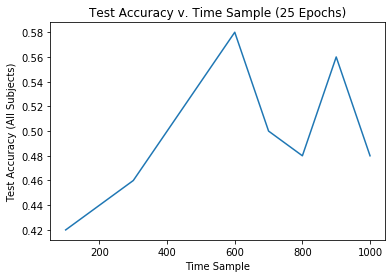

In [15]:
# Plot results of accuracy v. samples
plt.plot(steps, accuracy)
plt.title("Test Accuracy v. Time Sample (25 Epochs)")
plt.xlabel("Time Sample")
plt.ylabel("Test Accuracy (All Subjects)")